[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/combine-org/combine-notebooks/main?labpath=%2Fnotebooks%2Fsbml.ipynb)
<a href="https://colab.research.google.com/github/combine-org/combine-notebooks/blob/main/notebooks/sbml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab\"/></a>



# Simple SBML example


This notebook creates a simple model in [SBML Level 3 Version 1](https://synonym.caltech.edu/documents/specifications/level-3/version-1/core/release-3/) for illustration.  We then use [BasiCO](https://basico.readthedocs.io/en/latest/) to build and run a simulation of the SBML model.  BasiCO is a simplified interface to using COPASI from python.

## 1) Including libraries and helper functions

Note: Please uncomment the line below if you use the Google Colab.

In [14]:
#%pip install git+https://github.com/combine-org/combine-notebooks

In [15]:
from pathlib import Path

import libsbml
from basico import load_model, run_time_course, get_reaction_parameters, get_species

from combine_notebooks import RESULTS_DIR
from combine_notebooks.validation.validation_sbml import validate_sbml

In [16]:
def pretty_print(doc_before : libsbml.SBMLDocument, doc_after : libsbml.SBMLDocument = None):
    # Break the original SBML into lines
    original_document = libsbml.writeSBMLToString(doc_before)
    original_document_lines = original_document.split('\n')
    # Print the entire document in red
    if doc_after == None:
        original_document = '\n'.join(original_document_lines)
        print("\x1b[31m" + original_document + "\x1b[0m") # ANSI escape used to print colours here
    # If a new document is also given, highlight the lines that have changed
    else:
        # Split the updated SBML into lines
        new_document = libsbml.writeSBMLToString(doc_after)
        new_document_lines = new_document.split('\n')
        # Iterate over each new line
        for new_line in new_document_lines:
            # Print any new lines in red, otherwise print normally
            if new_line in original_document_lines:
                print(new_line)
            else:
                print("\x1b[31m" + new_line + "\x1b[0m") # ANSI escape used to print colours here

## 2) Declaring the SBML model

Create an empty SBMLDocument object.  You may also want to check for possible errors.  Even when the parameter values are hardwired like this, it is still possible for a failure to occur (e.g., if the operating system runs out of memory). 

In [17]:
document = libsbml.SBMLDocument(3, 1)

pretty_print(document)

<?xml version="1.0" encoding="UTF-8"?>
<sbml xmlns="http://www.sbml.org/sbml/level3/version1/core" level="3" version="1"/>



Create the basic Model object inside the SBMLDocument object.  To
produce a model with complete units for the reaction rates, we need
to set the 'timeUnits' and 'extentUnits' attributes on Model.  We
set 'substanceUnits' too, for good measure, though it's not strictly
necessary here because we also set the units for individual species
in their definitions.

In [18]:
start_doc = libsbml.SBMLDocument(document)

model = document.createModel()
model.setTimeUnits("second")
model.setExtentUnits("mole")
model.setSubstanceUnits('mole')

pretty_print(start_doc, document)

<?xml version="1.0" encoding="UTF-8"?>
<sbml xmlns="http://www.sbml.org/sbml/level3/version1/core" level="3" version="1">
  <model substanceUnits="mole" timeUnits="second" extentUnits="mole"/>
</sbml>



Create a unit definition we will need later.  Note that SBML Unit
objects must have all four attributes 'kind', 'exponent', 'scale'
and 'multiplier' defined.

In [19]:
start_doc = libsbml.SBMLDocument(document)

per_second = model.createUnitDefinition()
per_second.setId('per_second')
unit = per_second.createUnit()
unit.setKind(libsbml.UNIT_KIND_SECOND)
unit.setExponent(-1)
unit.setScale(0)
unit.setMultiplier(1)

pretty_print(start_doc, document)

<?xml version="1.0" encoding="UTF-8"?>
<sbml xmlns="http://www.sbml.org/sbml/level3/version1/core" level="3" version="1">
  <model substanceUnits="mole" timeUnits="second" extentUnits="mole">
    <listOfUnitDefinitions>
      <unitDefinition id="per_second">
        <listOfUnits>
          <unit kind="second" exponent="-1" scale="0" multiplier="1"/>
        </listOfUnits>
      </unitDefinition>
    </listOfUnitDefinitions>
  </model>
</sbml>



Create a compartment inside this model, and set the required
attributes for an SBML compartment in SBML Level 3.

In [20]:
start_doc = libsbml.SBMLDocument(document)

c1 = model.createCompartment()
c1.setId('c1')
c1.setConstant(True)
c1.setSize(1)
c1.setSpatialDimensions(3)
c1.setUnits('litre')

pretty_print(start_doc, document)

<?xml version="1.0" encoding="UTF-8"?>
<sbml xmlns="http://www.sbml.org/sbml/level3/version1/core" level="3" version="1">
  <model substanceUnits="mole" timeUnits="second" extentUnits="mole">
    <listOfUnitDefinitions>
      <unitDefinition id="per_second">
        <listOfUnits>
          <unit kind="second" exponent="-1" scale="0" multiplier="1"/>
        </listOfUnits>
      </unitDefinition>
    </listOfUnitDefinitions>
    <listOfCompartments>
      <compartment id="c1" spatialDimensions="3" size="1" units="litre" constant="true"/>
    </listOfCompartments>
  </model>
</sbml>



Create two species inside this model, set the required attributes
for each species in SBML Level 3 (which are the 'id', 'compartment',
'constant', 'hasOnlySubstanceUnits', and 'boundaryCondition'
attributes), and initialize the amount of the species along with the
units of the amount.

In [21]:
start_doc = libsbml.SBMLDocument(document)

s1 = model.createSpecies()
s1.setId('S1')
s1.setCompartment('c1')
s1.setConstant(False)
s1.setInitialAmount(5)
s1.setSubstanceUnits('mole')
s1.setBoundaryCondition(False)
s1.setHasOnlySubstanceUnits(False)

s2 = model.createSpecies()
s2.setId('S2')
s2.setCompartment('c1')
s2.setConstant(False)
s2.setInitialAmount(0)
s2.setSubstanceUnits('mole')
s2.setBoundaryCondition(False)
s2.setHasOnlySubstanceUnits(False)

pretty_print(start_doc, document)

<?xml version="1.0" encoding="UTF-8"?>
<sbml xmlns="http://www.sbml.org/sbml/level3/version1/core" level="3" version="1">
  <model substanceUnits="mole" timeUnits="second" extentUnits="mole">
    <listOfUnitDefinitions>
      <unitDefinition id="per_second">
        <listOfUnits>
          <unit kind="second" exponent="-1" scale="0" multiplier="1"/>
        </listOfUnits>
      </unitDefinition>
    </listOfUnitDefinitions>
    <listOfCompartments>
      <compartment id="c1" spatialDimensions="3" size="1" units="litre" constant="true"/>
    </listOfCompartments>
    <listOfSpecies>
      <species id="S1" compartment="c1" initialAmount="5" substanceUnits="mole" hasOnlySubstanceUnits="false" boundaryCondition="false" constant="false"/>
      <species id="S2" compartment="c1" initialAmount="0" substanceUnits="mole" hasOnlySubstanceUnits="false" boundaryCondition="false" constant="false"/>
    </listOfSpecies>
  </model>
</sbml>



Create a parameter object inside this model, set the required
attributes 'id' and 'constant' for a parameter in SBML Level 3, and
initialize the parameter with a value along with its units.

In [22]:
start_doc = libsbml.SBMLDocument(document)

k = model.createParameter()
k.setId('k')
k.setConstant(True)
k.setValue(1)
k.setUnits('per_second')

pretty_print(start_doc, document)

<?xml version="1.0" encoding="UTF-8"?>
<sbml xmlns="http://www.sbml.org/sbml/level3/version1/core" level="3" version="1">
  <model substanceUnits="mole" timeUnits="second" extentUnits="mole">
    <listOfUnitDefinitions>
      <unitDefinition id="per_second">
        <listOfUnits>
          <unit kind="second" exponent="-1" scale="0" multiplier="1"/>
        </listOfUnits>
      </unitDefinition>
    </listOfUnitDefinitions>
    <listOfCompartments>
      <compartment id="c1" spatialDimensions="3" size="1" units="litre" constant="true"/>
    </listOfCompartments>
    <listOfSpecies>
      <species id="S1" compartment="c1" initialAmount="5" substanceUnits="mole" hasOnlySubstanceUnits="false" boundaryCondition="false" constant="false"/>
      <species id="S2" compartment="c1" initialAmount="0" substanceUnits="mole" hasOnlySubstanceUnits="false" boundaryCondition="false" constant="false"/>
    </listOfSpecies>
    <listOfParameters>
      <parameter id="k" value="1" units="per_second" cons

Create a reaction inside this model, set the reactants and products.  We
set the minimum required attributes for all of these objects.  The
units of the reaction rate are determined from the 'timeUnits' and
'extentUnits' attributes on the Model object.
NOTE: The reactants and products refer the species already in the model.  

In [23]:
start_doc = libsbml.SBMLDocument(document)

r1 = model.createReaction()
r1.setId('r1')
r1.setReversible(False)
r1.setFast(False)

species_ref1 = r1.createReactant()
species_ref1.setSpecies('S1')
species_ref1.setConstant(True)

species_ref2 = r1.createProduct()
species_ref2.setSpecies('S2')
species_ref2.setConstant(True)

pretty_print(start_doc, document)

<?xml version="1.0" encoding="UTF-8"?>
<sbml xmlns="http://www.sbml.org/sbml/level3/version1/core" level="3" version="1">
  <model substanceUnits="mole" timeUnits="second" extentUnits="mole">
    <listOfUnitDefinitions>
      <unitDefinition id="per_second">
        <listOfUnits>
          <unit kind="second" exponent="-1" scale="0" multiplier="1"/>
        </listOfUnits>
      </unitDefinition>
    </listOfUnitDefinitions>
    <listOfCompartments>
      <compartment id="c1" spatialDimensions="3" size="1" units="litre" constant="true"/>
    </listOfCompartments>
    <listOfSpecies>
      <species id="S1" compartment="c1" initialAmount="5" substanceUnits="mole" hasOnlySubstanceUnits="false" boundaryCondition="false" constant="false"/>
      <species id="S2" compartment="c1" initialAmount="0" substanceUnits="mole" hasOnlySubstanceUnits="false" boundaryCondition="false" constant="false"/>
    </listOfSpecies>
    <listOfParameters>
      <parameter id="k" value="1" units="per_second" cons

Set the reaction rate expression (the SBML "kinetic law").  Here we are using MathML to model the equation ; $k \times S1 \times c1$



In [24]:
start_doc = libsbml.SBMLDocument(document)

math_ast = libsbml.parseL3Formula('k * S1 * c1')

kinetic_law = r1.createKineticLaw()
kinetic_law.setMath(math_ast)

pretty_print(start_doc, document)


<?xml version="1.0" encoding="UTF-8"?>
<sbml xmlns="http://www.sbml.org/sbml/level3/version1/core" level="3" version="1">
  <model substanceUnits="mole" timeUnits="second" extentUnits="mole">
    <listOfUnitDefinitions>
      <unitDefinition id="per_second">
        <listOfUnits>
          <unit kind="second" exponent="-1" scale="0" multiplier="1"/>
        </listOfUnits>
      </unitDefinition>
    </listOfUnitDefinitions>
    <listOfCompartments>
      <compartment id="c1" spatialDimensions="3" size="1" units="litre" constant="true"/>
    </listOfCompartments>
    <listOfSpecies>
      <species id="S1" compartment="c1" initialAmount="5" substanceUnits="mole" hasOnlySubstanceUnits="false" boundaryCondition="false" constant="false"/>
      <species id="S2" compartment="c1" initialAmount="0" substanceUnits="mole" hasOnlySubstanceUnits="false" boundaryCondition="false" constant="false"/>
    </listOfSpecies>
    <listOfParameters>
      <parameter id="k" value="1" units="per_second" cons

## 3) Write, print and validate the generated model

And we're done creating the basic model.  Here we will check if the SBML is valid.

In [25]:
# validate file
validate_sbml(document, units_consistency=False)

--------------------------------------------------------------------------------
validation error(s)      : 0
validation warning(s)    : 0
--------------------------------------------------------------------------------


Now save a text string containing the model into an XML file.

In [26]:
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
file_loc = RESULTS_DIR / "hello_world_sbml.xml"
libsbml.writeSBMLToFile(document, str(file_loc))
xml = open(file_loc).read()
print(xml)

<?xml version="1.0" encoding="UTF-8"?>
<sbml xmlns="http://www.sbml.org/sbml/level3/version1/core" level="3" version="1">
  <model substanceUnits="mole" timeUnits="second" extentUnits="mole">
    <listOfUnitDefinitions>
      <unitDefinition id="per_second">
        <listOfUnits>
          <unit kind="second" exponent="-1" scale="0" multiplier="1"/>
        </listOfUnits>
      </unitDefinition>
    </listOfUnitDefinitions>
    <listOfCompartments>
      <compartment id="c1" spatialDimensions="3" size="1" units="litre" constant="true"/>
    </listOfCompartments>
    <listOfSpecies>
      <species id="S1" compartment="c1" initialAmount="5" substanceUnits="mole" hasOnlySubstanceUnits="false" boundaryCondition="false" constant="false"/>
      <species id="S2" compartment="c1" initialAmount="0" substanceUnits="mole" hasOnlySubstanceUnits="false" boundaryCondition="false" constant="false"/>
    </listOfSpecies>
    <listOfParameters>
      <parameter id="k" value="1" units="per_second" cons

## 4) Simulating the model

Now we will load to model into COPASI (basico) so we can run a simulation.

In [27]:
model = load_model(file_loc)

To verify our species parameters for s1 and s2 we can call get_species, which returns a dataframe with all information about the species.

In [28]:
get_species()

,compartment,type,unit,initial_concentration,initial_particle_number,initial_expression,expression,concentration,particle_number,rate,particle_number_rate,key,sbml_id
name,,,,,,,,,,,,,
S1,c1,reactions,mol/l,5.0,3.011071e+24,,,5.0,3.011071e+24,-5.0,-3.011071e+24,Metabolite_0,S1
S2,c1,reactions,mol/l,0.0,0.000000e+00,,,0.0,0.000000e+00,5.0,3.011071e+24,Metabolite_1,S2


To see the kinetic paramters of our recation we can use get_reaction_parameters.

In [29]:
get_reaction_parameters()

,value,reaction,type,mapped_to
name,,,,
(r1).k1,1.0,r1,global,k


Now lets simulate our model for 10 seconds.

<AxesSubplot: xlabel='Time'>

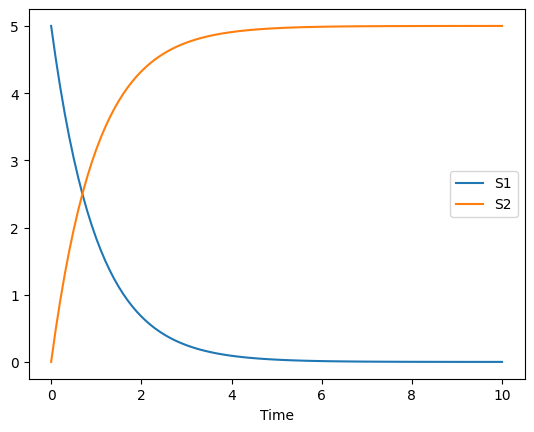

In [30]:
result = run_time_course(duration=10)
result.plot()